# Gradient Enhanced - Refined Stratified Sampling Example 1
Author: Mohit S. Chauhan Date: Aug 20, 2018

In this example, Stratified sampling is used to generate samples from Uniform distribution and sample expnsion is done using Refined Stratified Sampling method.

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the STS and RSS class from UQpy.

In [1]:
from UQpy.SampleMethods import STS
from UQpy.SampleMethods import RSS
from UQpy.Surrogates import Krig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
import numpy as np
import time

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [2]:
x = STS(dimension=2, dist_name=['Uniform', 'Uniform'], dist_params=[[0, 1], [0, 1]], sts_design=[4, 4])

UQpy: Performing STS design...
Done!


This plot shows the samples and stratas generated by the STS class.

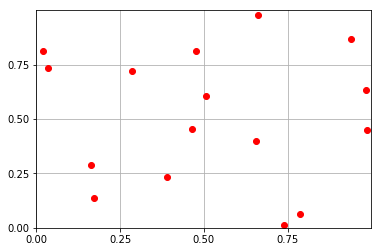

In [3]:
fig2 = plt.figure()
plt.plot(x.samples[:, 0], x.samples[:, 1], 'ro')
ax = fig2.gca()
ax.set_xticks(np.arange(0, 1, 0.25))
ax.set_yticks(np.arange(0, 1, 0.25))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.show()

In [4]:
def y_func(z):
    return 1/(6.2727*(abs(0.3-z[:, 0]**2-z[:, 1]**2)+0.01))

corr_model = 'Exponential'

In [5]:
%%capture
K = Krig(samples=x.samples, values=y_func(x.samples), reg_model='Quadratic', corr_model=corr_model)

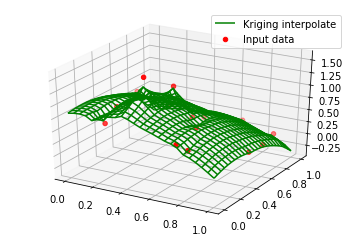

In [6]:
num = 25
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K.interpolate(np.array([x1v[i, j], x2v[i, j]]))

fig = plt.figure()
ax = plt.axes(projection='3d')
# Plot for estimated values
kr = ax.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax.scatter3D(x.samples[:, 0], x.samples[:, 1], y_func(x.samples), color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()
fig.savefig('I_interpolate.png')

Using UQpy RSS class to expand samples generated by STS class. In this example, two new samples are generated and cut_type is assigned as 1, i.e. strata will be cut randomly along longest direction with maximum gradient. Notice that total number of samples are more than min train size, this implies after generating 150 samples, RSS class uses local surrogate updating to generate further samples.

In [7]:
%%capture
z = RSS(x=x, func=y_func, option='Gradient', meta='Kriging', nSamples=200, cut_type=1,
        min_train_size=150, step_size=0.005, corr_model=corr_model);

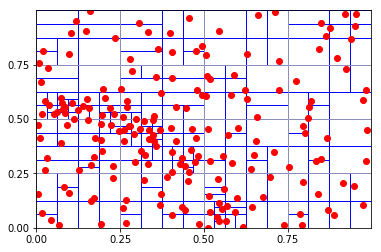

In [8]:
fig3 = plt.figure()
ax = fig3.gca()
ax.set_xticks(np.arange(0, 1, 0.25))
ax.set_yticks(np.arange(0, 1, 0.25))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(z.samples[:, 0], z.samples[:, 1], 'ro')
for i in range(z.nSamples):
    rect = patches.Rectangle(z.strata.origins[i], z.strata.widths[i, 0], z.strata.widths[i, 1], linewidth=1,
                             edgecolor='b', facecolor='none')
    ax.add_patch(rect)
plt.grid()
plt.show()
fig3.savefig('FinalSamples.png')

In [9]:
%%capture
K2 = Krig(samples=z.samples, values=y_func(z.samples), reg_model='Quadratic', corr_model=corr_model,
          corr_model_params=z.corr_model_params)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


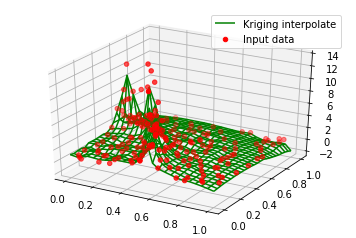

In [10]:
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K2.interpolate(np.array([x1v[i, j], x2v[i, j]]))

fig4 = plt.figure()
a1 = fig4.gca()
a1 = plt.axes(projection='3d')
# Plot for estimated values
kr = a1.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = a1.scatter3D(z.samples[:, 0], z.samples[:, 1], y_func(z.samples), color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()
fig4.savefig('F_interpolate.png')